# Imports

In [52]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

# Data

## Data Exploration

In [53]:
df = pd.read_csv("Data/celldata.csv")

In [54]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
0,632,Germany,Female,50,5,107959.39,1,1,1,6985,1
1,649,France,Female,42,7,0.00,2,0,1,22974,0
2,595,France,Male,29,6,150685.79,1,1,0,87771,0
3,653,Spain,Male,35,6,116662.96,2,1,1,23864,0
4,559,Spain,Female,40,7,144470.77,1,1,1,18918,0


In [55]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Salary', 'Churn'],
      dtype='object')

In [56]:
df.dtypes

CreditScore         int64
Geography          object
Gender             object
Age                 int64
Tenure              int64
Balance           float64
NumOfProducts       int64
HasCrCard           int64
IsActiveMember      int64
Salary              int64
Churn               int64
dtype: object

In [57]:
set(df["Geography"].values)

{'France', 'Germany', 'Spain'}

In [58]:
set(df['Gender'].values)

{'Female', 'Male'}

In [59]:
df = pd.get_dummies(df, columns=["Gender"], prefix="Gender")

In [60]:
df

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn,Gender_Female,Gender_Male
0,632,Germany,50,5,107959.39,1,1,1,6985,1,True,False
1,649,France,42,7,0.00,2,0,1,22974,0,True,False
2,595,France,29,6,150685.79,1,1,0,87771,0,False,True
3,653,Spain,35,6,116662.96,2,1,1,23864,0,False,True
4,559,Spain,40,7,144470.77,1,1,1,18918,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,560,France,44,5,143244.97,1,1,0,98661,0,True,False
7996,410,France,33,6,125789.69,1,0,0,66334,1,False,True
7997,610,France,36,4,129440.30,2,1,0,102638,0,False,True
7998,490,France,33,1,0.00,2,1,1,80793,0,False,True


In [61]:
encoder = OneHotEncoder(drop=None, sparse_output=False)

encoded = encoder.fit_transform(df[["Geography"]])

encoded_df = pd.DataFrame(
    encoded, 
    columns=encoder.get_feature_names_out(["Geography"])
)

df_encoded = pd.concat([df.drop(columns=["Geography"]), encoded_df], axis=1)

In [62]:
df_encoded

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
0,632,50,5,107959.39,1,1,1,6985,1,True,False,0.0,1.0,0.0
1,649,42,7,0.00,2,0,1,22974,0,True,False,1.0,0.0,0.0
2,595,29,6,150685.79,1,1,0,87771,0,False,True,1.0,0.0,0.0
3,653,35,6,116662.96,2,1,1,23864,0,False,True,0.0,0.0,1.0
4,559,40,7,144470.77,1,1,1,18918,0,True,False,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,560,44,5,143244.97,1,1,0,98661,0,True,False,1.0,0.0,0.0
7996,410,33,6,125789.69,1,0,0,66334,1,False,True,1.0,0.0,0.0
7997,610,36,4,129440.30,2,1,0,102638,0,False,True,1.0,0.0,0.0
7998,490,33,1,0.00,2,1,1,80793,0,False,True,1.0,0.0,0.0


<Axes: >

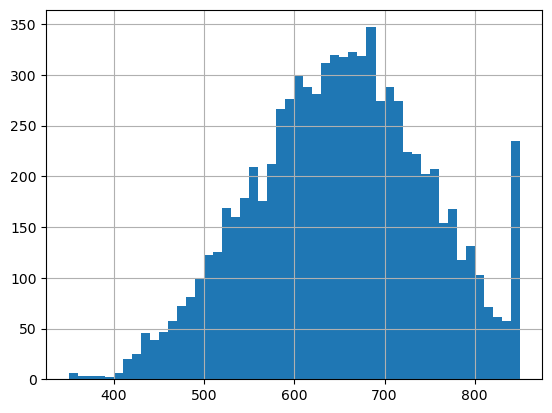

In [63]:
df['CreditScore'].hist(bins=50)

In [64]:
df['CreditScore'].describe()

count    8000.000000
mean      650.805000
std        96.721648
min       350.000000
25%       584.000000
50%       652.000000
75%       718.000000
max       850.000000
Name: CreditScore, dtype: float64

<Axes: >

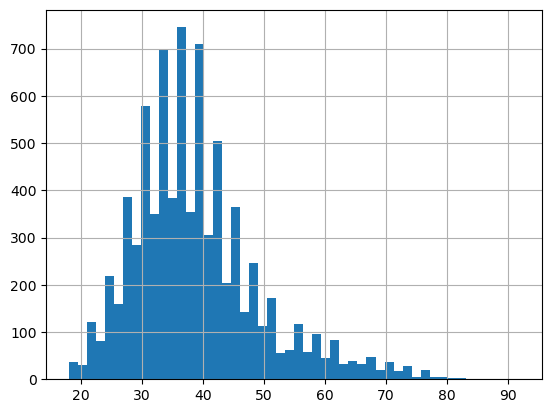

In [65]:
df['Age'].hist(bins=50)

In [66]:
df['Age'].describe()

count    8000.000000
mean       38.871625
std        10.446006
min        18.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        92.000000
Name: Age, dtype: float64

<Axes: >

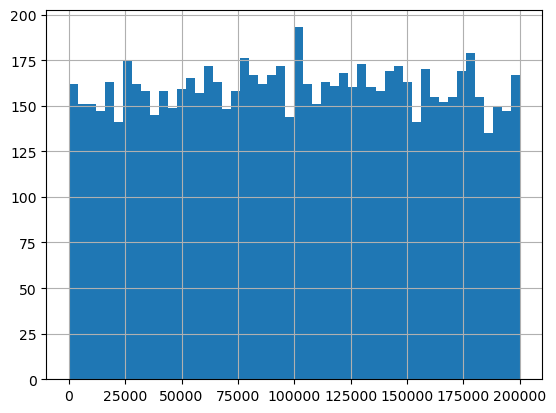

In [67]:
df['Salary'].hist(bins=50)

In [68]:
df['Salary'].describe()

count      8000.000000
mean     100211.396750
std       57165.688096
min          12.000000
25%       51464.500000
50%      100583.000000
75%      149068.000000
max      199992.000000
Name: Salary, dtype: float64

<Axes: >

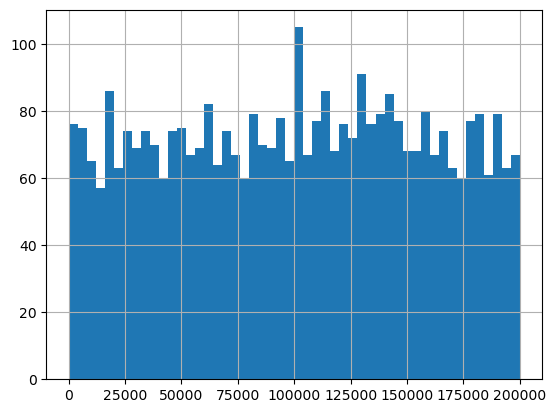

In [69]:
df[df['Gender_Female']==True]['Salary'].hist(bins=50)

In [70]:
df[df['Gender_Female']==True]['Salary'].describe()

count      3627.000000
mean     100444.200717
std       56962.409230
min          92.000000
25%       51224.500000
50%      102234.000000
75%      147979.500000
max      199992.000000
Name: Salary, dtype: float64

<Axes: >

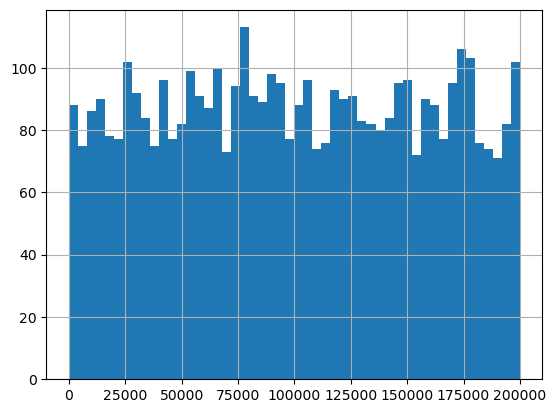

In [71]:
df[df['Gender_Male']==True]['Salary'].hist(bins=50)

In [72]:
df[df['Gender_Male']==True]['Salary'].describe()

count      4373.000000
mean     100018.307340
std       57339.535394
min          12.000000
25%       51638.000000
50%       98570.000000
75%      149576.000000
max      199953.000000
Name: Salary, dtype: float64

<Axes: >

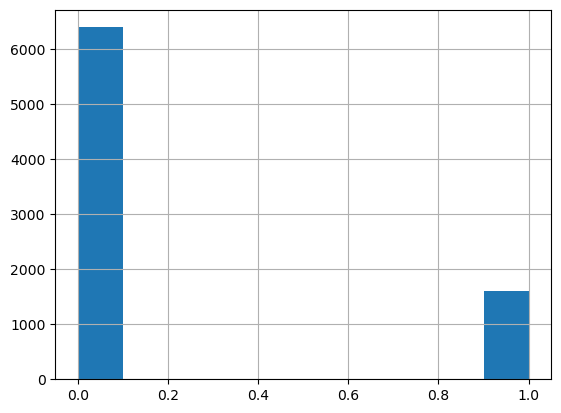

In [73]:
df['Churn'].hist()

In [74]:
df['Churn'].describe()

count    8000.000000
mean        0.201125
std         0.400866
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Churn, dtype: float64

In [75]:
df_encoded.dtypes

CreditScore            int64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
Salary                 int64
Churn                  int64
Gender_Female           bool
Gender_Male             bool
Geography_France     float64
Geography_Germany    float64
Geography_Spain      float64
dtype: object

## Weighting the churn to avoid false prediction

In [76]:
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]

In [77]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
print(dict(zip(np.unique(y), class_weights)))

{0: 0.6258801439524331, 1: 2.4860161591050343}


In [78]:
weights = np.array([class_weights[y_i] for y_i in y])

# Testing different models

## Naive Bayes

### Simple implementation

In [79]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test, w_train, w_test= train_test_split(X, y, weights, test_size=0.2,random_state=42)

model = GaussianNB()
model.fit(X_train,y_train, sample_weight=w_train)
y_pred = model.predict(X_test)

In [80]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.7075
0.3802083333333333
0.6636363636363637
0.48344370860927155


In [81]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1270
           1       0.38      0.66      0.48       330

    accuracy                           0.71      1600
   macro avg       0.64      0.69      0.64      1600
weighted avg       0.79      0.71      0.73      1600



### Cross Validation procedure

In [82]:
kf = KFold(n_splits=5)

kf.get_n_splits(X)

scoring = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {key: [] for key in scoring.keys()}

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    w_train = weights[train_idx]

    # Modèle Naive Bayes avec pondération
    model = GaussianNB()
    model.fit(X_train, y_train, sample_weight=w_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # nécessaire pour roc_auc

    # Calcul des scores
    results['accuracy'].append(accuracy_score(y_test, y_pred))
    results['auc'].append(roc_auc_score(y_test, y_proba))
    results['f1'].append(f1_score(y_test, y_pred))
    results['precision'].append(precision_score(y_test, y_pred))
    results['recall'].append(recall_score(y_test, y_pred))

# Moyennes sur les folds
for metric in results:
    print(f"{metric}: {np.mean(results[metric]):.4f}")

accuracy: 0.7103
auc: 0.7392
f1: 0.4743
precision: 0.3740
recall: 0.6496


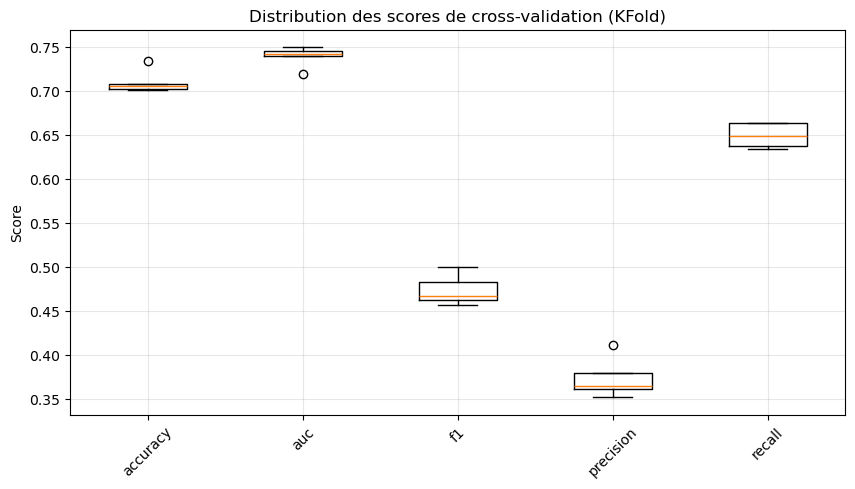

In [83]:
keys = list(results.keys())
values = [results[key] for key in keys]

plt.figure(figsize=(10, 5))
plt.boxplot(values)
plt.xticks(range(1, len(keys) + 1), keys, rotation=45)
plt.title("Distribution des scores de cross-validation (KFold)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.show()

### Standardisation + Cross Validation

In [84]:
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ('scaler', StandardScaler()),
    ('gaussiannb', GaussianNB())
])

model.fit(X_train, y_train, gaussiannb__sample_weight=w_train)
y_pred = model.predict(X_test)


In [85]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1266
           1       0.41      0.67      0.50       334

    accuracy                           0.73      1600
   macro avg       0.65      0.70      0.66      1600
weighted avg       0.79      0.73      0.75      1600



In [86]:
confusion_matrix(y_test,y_pred)

array([[939, 327],
       [111, 223]])

In [87]:
y_score = model.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_score)
auc(fpr,tpr)

0.7791263526173333

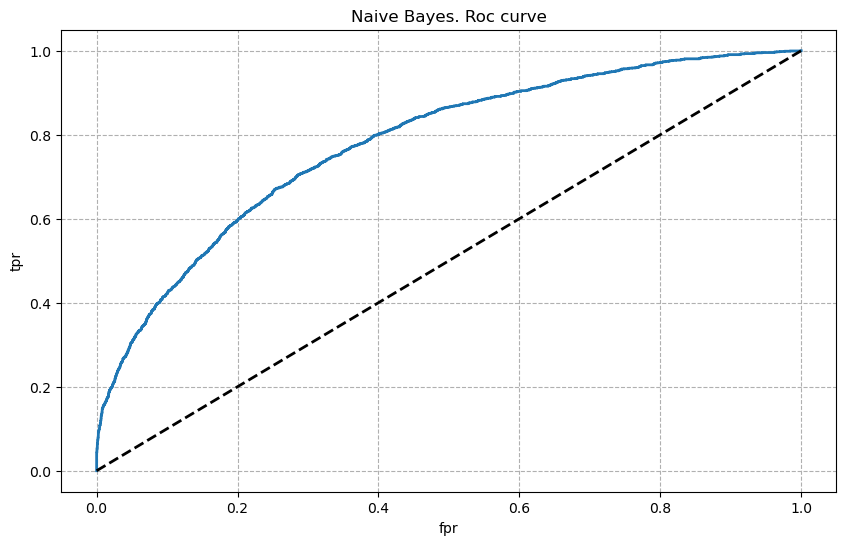

In [88]:
y_proba= model.predict_proba(X)[:,1];
fpr, tpr, thresholds= roc_curve(y, y_proba);
figure= plt.figure(figsize=(10,6));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Naive Bayes. Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed') 
plt.show()

## Linear Discriminant Analysis (LDA)

### First Attempt

In [89]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2,random_state=42)

lda = LinearDiscriminantAnalysis(n_components=1, store_covariance=True)

lda.fit(X_train,y_train)
y_pred_train = lda.predict(X_train)
y_pred = lda.predict(X_test)

In [90]:
acc = accuracy_score(y_train, y_pred_train)
prec = precision_score(y_train, y_pred_train, average='weighted')
rec = recall_score(y_train, y_pred_train, average='weighted')
f1 = f1_score(y_train, y_pred_train, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

Accuracy: 0.809
Precision: 0.775
Recall: 0.809
F1-score: 0.772

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      5121
           1       0.56      0.20      0.30      1279

    accuracy                           0.81      6400
   macro avg       0.69      0.58      0.59      6400
weighted avg       0.78      0.81      0.77      6400



In [91]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.808
Precision: 0.778
Recall: 0.808
F1-score: 0.773

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      1270
           1       0.59      0.23      0.33       330

    accuracy                           0.81      1600
   macro avg       0.71      0.59      0.61      1600
weighted avg       0.78      0.81      0.77      1600



### Cross Validation

In [92]:
kf = KFold(n_splits=5)

kf.get_n_splits(X)

scoring = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

cv_results = cross_validate(lda, X, y, cv=kf, scoring=scoring, return_train_score=True)

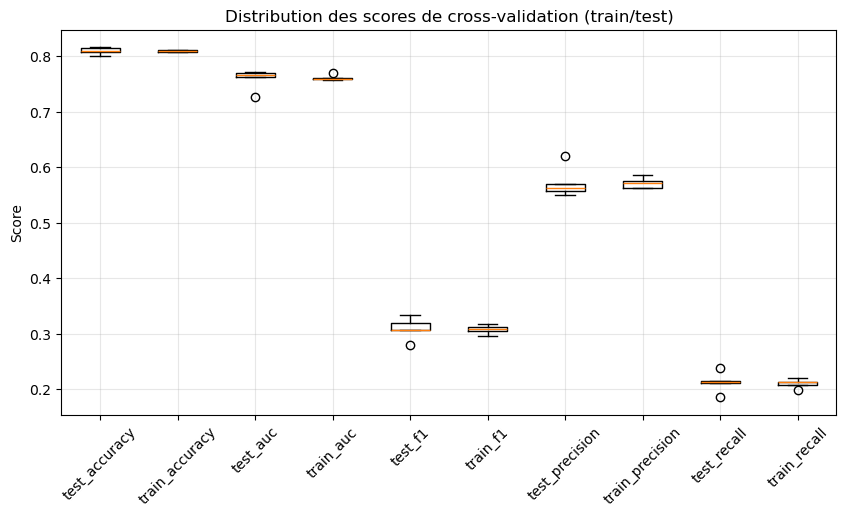

In [93]:
keys = [key for key in cv_results.keys() if key.startswith('test') or key.startswith('train')]
values = [cv_results[key] for key in keys]

plt.figure(figsize=(10, 5))
plt.boxplot(values)
plt.xticks(range(1, len(keys) + 1), keys, rotation=45)
plt.title("Distribution des scores de cross-validation (train/test)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.show()

### ROC Curve

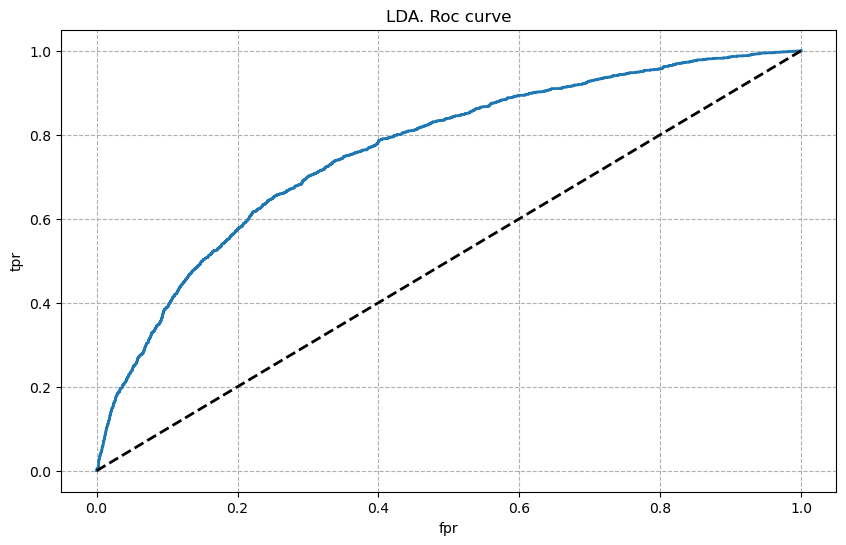

In [94]:
y_proba= lda.predict_proba(X)[:,1]
fpr, tpr, thresholds= roc_curve(y, y_proba)
figure= plt.figure(figsize=(10,6))
plt.plot(fpr,tpr, linewidth= 2)
plt.title('LDA. Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed') 
plt.show()

## Quadratic Discriminant Analysis (QDA)

### First Attempt

In [95]:
X_train, X_test, y_train, y_test, w_train, w_train = train_test_split(X,y, weights, test_size=0.2, random_state=42)

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train,y_train)
y_pred = qda.predict(X_test)

/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [96]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82      1270
           1       0.33      0.37      0.35       330

    accuracy                           0.71      1600
   macro avg       0.58      0.59      0.58      1600
weighted avg       0.73      0.71      0.72      1600



In [97]:
accuracy_score(y_test, y_pred)

0.714375

### Cross Validation

In [98]:
kf = KFold(n_splits=5)

kf.get_n_splits(X)

scoring = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

cv_results = cross_validate(qda, X, y, cv=kf, scoring=scoring, return_train_score=True)

/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might h

In [99]:
cv_results

{'fit_time': array([0.00660086, 0.00293493, 0.00297904, 0.00256205, 0.00314307]),
 'score_time': array([0.00417113, 0.00581908, 0.00468802, 0.00409818, 0.00393486]),
 'test_accuracy': array([0.76125 , 0.4925  , 0.2525  , 0.76875 , 0.796875]),
 'train_accuracy': array([0.7453125 , 0.489375  , 0.2328125 , 0.76890625, 0.7940625 ]),
 'test_auc': array([0.57703676, 0.5280917 , 0.5427196 , 0.59960821, 0.69798198]),
 'train_auc': array([0.57051894, 0.51192947, 0.52917913, 0.56640251, 0.70585571]),
 'test_f1': array([0.24505929, 0.32220367, 0.35140998, 0.27165354, 0.40585009]),
 'train_f1': array([0.23831776, 0.30733362, 0.3348686 , 0.23723569, 0.41160714]),
 'test_precision': array([0.31632653, 0.22107675, 0.21471173, 0.37297297, 0.48051948]),
 'train_precision': array([0.30321046, 0.21112405, 0.20235756, 0.35222052, 0.48680042]),
 'test_recall': array([0.2       , 0.59384615, 0.96716418, 0.21362229, 0.35126582]),
 'train_recall': array([0.19630485, 0.56464174, 0.97017268, 0.17884914, 0.35653

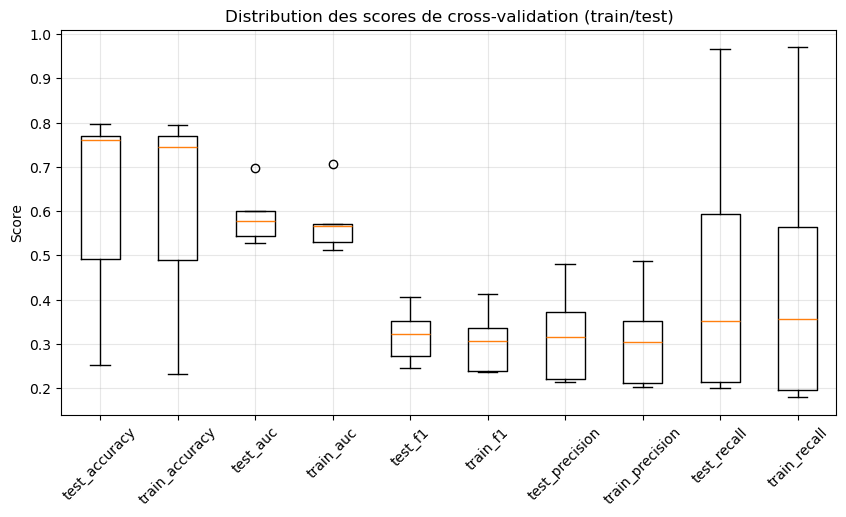

In [100]:
keys = [key for key in cv_results.keys() if key.startswith('test') or key.startswith('train')]
values = [cv_results[key] for key in keys]

plt.figure(figsize=(10, 5))
plt.boxplot(values)
plt.xticks(range(1, len(keys) + 1), keys, rotation=45)
plt.title("Distribution des scores de cross-validation (train/test)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.show()

### ROC Curve

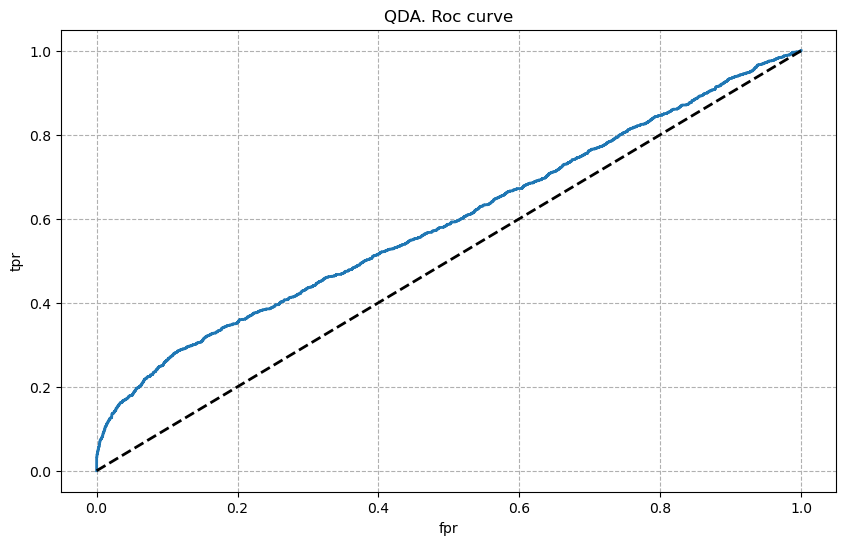

In [101]:
y_proba= qda.predict_proba(X)[:,1]
fpr, tpr, thresholds= roc_curve(y, y_proba)
figure= plt.figure(figsize=(10,6))
plt.plot(fpr,tpr, linewidth= 2)
plt.title('QDA. Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed') 
plt.show()

## Logistic Regression

### Naive Attempt

In [102]:
X_train,X_test,y_train,y_test, w_train, w_test= train_test_split(X, y, weights, test_size=0.2,random_state=42)

logreg= LogisticRegression(C=1e5,max_iter=100000)

logreg.fit(X_train,y_train, sample_weight=w_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,100000.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100000
,multi_class,'deprecated'


In [103]:
y_pred = logreg.predict(X_test)

In [104]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78      1270
           1       0.37      0.69      0.48       330

    accuracy                           0.69      1600
   macro avg       0.63      0.69      0.63      1600
weighted avg       0.79      0.69      0.72      1600



In [105]:
accuracy_score(y_test,y_pred)

0.69125

### Cross Validation

In [106]:
kf = KFold(n_splits=5)

kf.get_n_splits(X)

scoring = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

cv_results = cross_validate(logreg, X, y, cv=kf, scoring=scoring, return_train_score=True)

/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 13137 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [107]:
cv_results

{'fit_time': array([1.72934008, 1.7239449 , 2.04053783, 0.6344521 , 0.96015811]),
 'score_time': array([0.00411701, 0.00421619, 0.0043869 , 0.00425696, 0.00404906]),
 'test_accuracy': array([0.814375, 0.82    , 0.8025  , 0.81375 , 0.810625]),
 'train_accuracy': array([0.8103125 , 0.81265625, 0.8146875 , 0.81375   , 0.81203125]),
 'test_auc': array([0.76020755, 0.76867813, 0.72350894, 0.76214813, 0.77034781]),
 'train_auc': array([0.75794283, 0.75537986, 0.76751559, 0.75661679, 0.75638657]),
 'test_f1': array([0.30444965, 0.29756098, 0.26851852, 0.29383886, 0.28368794]),
 'train_f1': array([0.29171529, 0.2755287 , 0.30724299, 0.29300119, 0.29525483]),
 'test_precision': array([0.55555556, 0.71764706, 0.59793814, 0.62626263, 0.56074766]),
 'train_precision': array([0.60240964, 0.61455526, 0.60045662, 0.6175    , 0.60869565]),
 'test_recall': array([0.20967742, 0.18769231, 0.17313433, 0.19195046, 0.18987342]),
 'train_recall': array([0.19245574, 0.17757009, 0.20643642, 0.19206843, 0.19489

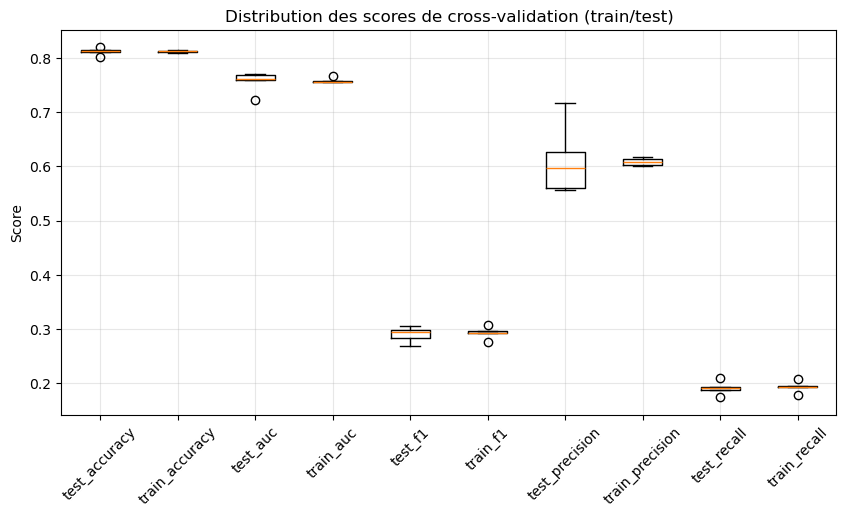

In [108]:
keys = [key for key in cv_results.keys() if key.startswith('test') or key.startswith('train')]
values = [cv_results[key] for key in keys]

plt.figure(figsize=(10, 5))
plt.boxplot(values)
plt.xticks(range(1, len(keys) + 1), keys, rotation=45)
plt.title("Distribution des scores de cross-validation (train/test)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.show()

### ROC Curve

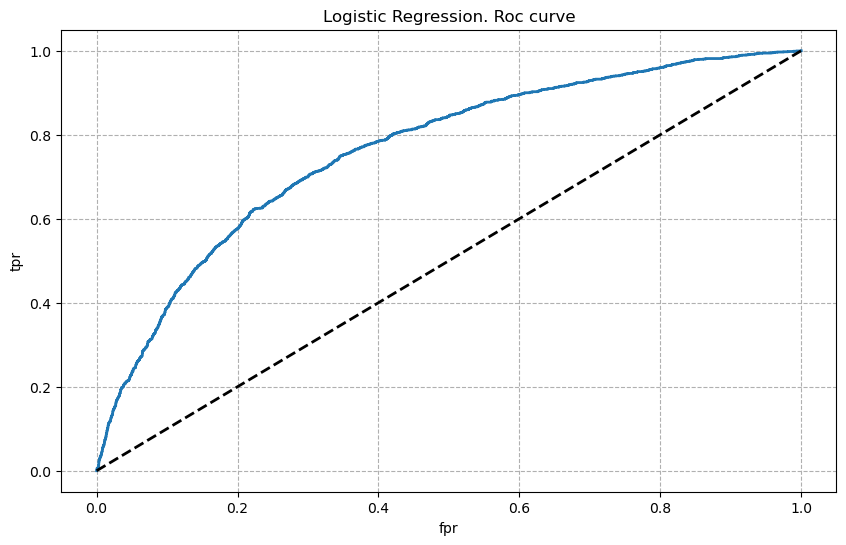

In [109]:
y_proba= logreg.predict_proba(X)[:,1]
fpr, tpr, thresholds= roc_curve(y, y_proba)
figure= plt.figure(figsize=(10,6))
plt.plot(fpr,tpr, linewidth= 2)
plt.title('Logistic Regression. Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed') 
plt.show()

## KNN Model

### First attempt

In [110]:
knn= KNeighborsClassifier(n_neighbors=5)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

knn.fit(X_train,y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [111]:
y_pred = knn.predict(X_test)

In [112]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.75375
Precision: 0.682317892735379
Recall: 0.75375
F1-score: 0.7071193261484063


In [113]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      1270
           1       0.24      0.09      0.13       330

    accuracy                           0.75      1600
   macro avg       0.52      0.51      0.49      1600
weighted avg       0.68      0.75      0.71      1600



### Cross Validation

In [114]:
kf = KFold(n_splits=5)

kf.get_n_splits(X)

scoring = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

cv_results = cross_validate(knn, X, y, cv=kf, scoring=scoring, return_train_score=True)

In [115]:
cv_results

{'fit_time': array([0.00924206, 0.00191903, 0.00186706, 0.0019269 , 0.00192308]),
 'score_time': array([0.0297358 , 0.02413416, 0.02391887, 0.02468824, 0.02388096]),
 'test_accuracy': array([0.76125 , 0.76875 , 0.77125 , 0.76375 , 0.766875]),
 'train_accuracy': array([0.81875   , 0.81875   , 0.8146875 , 0.81328125, 0.820625  ]),
 'test_auc': array([0.49988247, 0.54490136, 0.54198808, 0.51463497, 0.51340993]),
 'train_auc': array([0.81180734, 0.80373626, 0.80300065, 0.8087332 , 0.81335673]),
 'test_f1': array([0.10747664, 0.11483254, 0.14485981, 0.1369863 , 0.1097852 ]),
 'train_f1': array([0.33562428, 0.31034483, 0.29655991, 0.30239346, 0.33947066]),
 'test_precision': array([0.19491525, 0.25806452, 0.33333333, 0.26086957, 0.22330097]),
 'train_precision': array([0.65548098, 0.65577889, 0.60679612, 0.60655738, 0.66292135]),
 'test_recall': array([0.07419355, 0.07384615, 0.09253731, 0.09287926, 0.07278481]),
 'train_recall': array([0.22555812, 0.20327103, 0.19623234, 0.20139969, 0.22815

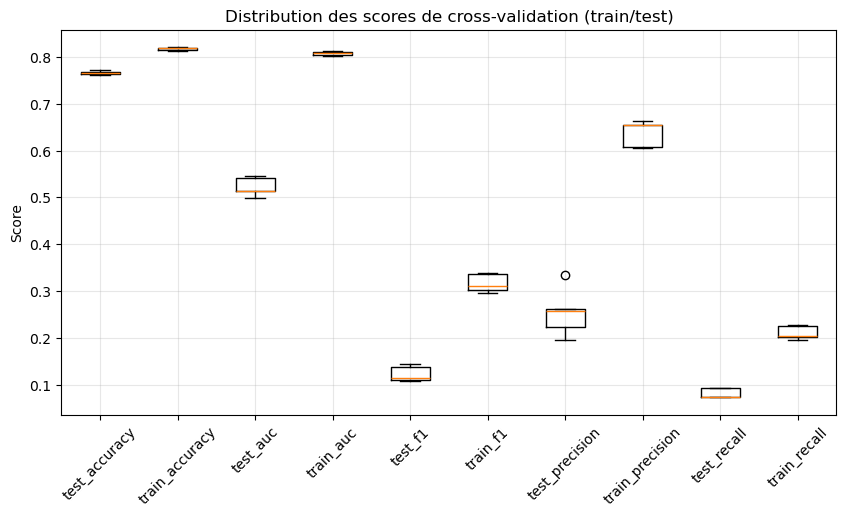

In [116]:
keys = [key for key in cv_results.keys() if key.startswith('test') or key.startswith('train')]
values = [cv_results[key] for key in keys]

plt.figure(figsize=(10, 5))
plt.boxplot(values)
plt.xticks(range(1, len(keys) + 1), keys, rotation=45)
plt.title("Distribution des scores de cross-validation (train/test)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.show()

### ROC Curve

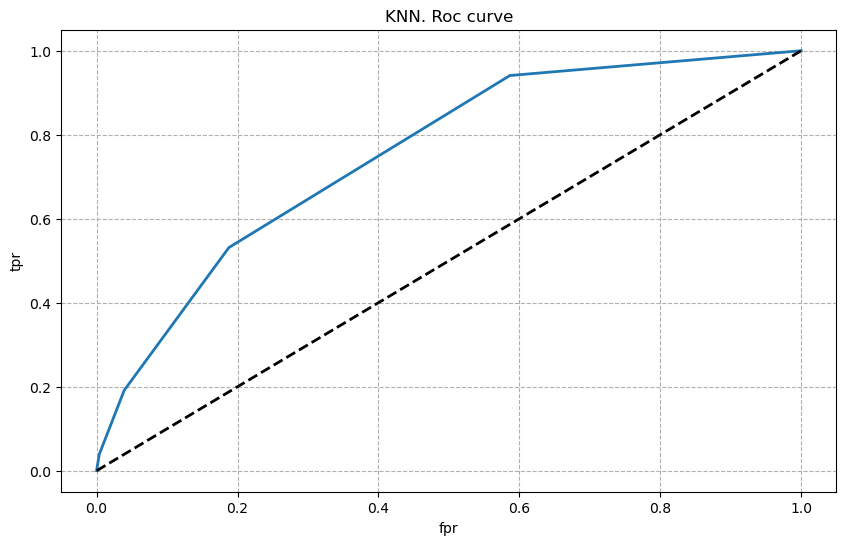

In [117]:
y_proba= knn.predict_proba(X)[:,1]
fpr, tpr, thresholds= roc_curve(y, y_proba)
figure= plt.figure(figsize=(10,6))
plt.plot(fpr,tpr, linewidth= 2)
plt.title('KNN. Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed') 
plt.show()

## Decision Tree

### Simple model

In [118]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y, weights, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()
treefit = model.fit(X_train, y_train, sample_weight=w_train)
y_pred = treefit.predict_proba(X_test)

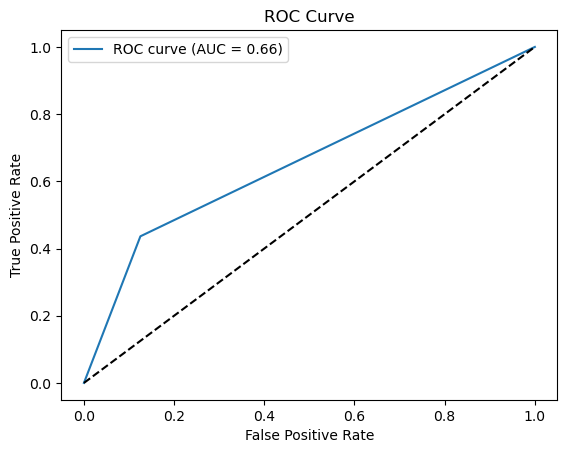

In [119]:
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
plt.plot(fpr, tpr, label="ROC curve (AUC = %.2f)" % roc_auc_score(y_test, y_pred[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

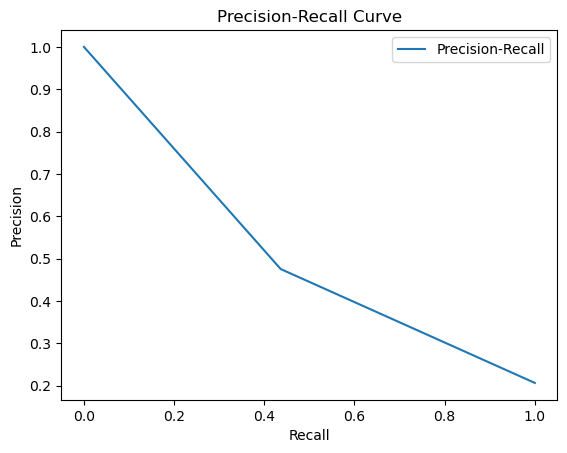

In [120]:
# Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])
plt.plot(recall, precision, label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

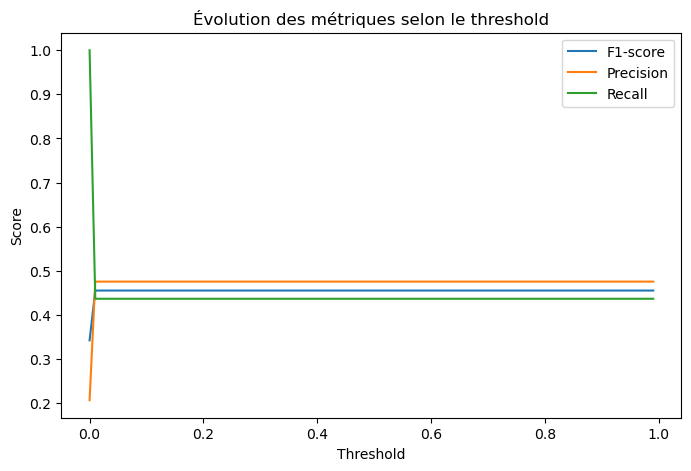

In [121]:
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    y_pred_class = (y_pred[:, 1] >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_class))
    precisions.append(precision_score(y_test, y_pred_class))
    recalls.append(recall_score(y_test, y_pred_class))

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, label="F1-score")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Évolution des métriques selon le threshold")
plt.show()

In [122]:
best_t = thresholds[np.argmax(f1_scores)]
print("Meilleur seuil selon F1-score :", best_t)

Meilleur seuil selon F1-score : 0.01


In [123]:
y_pred_class = (y_pred[:, 1] > 0.01).astype(int)

print("Accuracy :", accuracy_score(y_test, y_pred_class))
print("Precision :", precision_score(y_test, y_pred_class))
print("Recall :", recall_score(y_test, y_pred_class))
print("F1-score :", f1_score(y_test, y_pred_class))
print("ROC-AUC :", roc_auc_score(y_test, y_pred[:, 1]))

print("\nConfusion Matrix :\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report :\n", classification_report(y_test, y_pred_class))

Accuracy : 0.784375
Precision : 0.4752475247524752
Recall : 0.43636363636363634
F1-score : 0.4549763033175355
ROC-AUC : 0.6555833929849677

Confusion Matrix :
 [[1111  159]
 [ 186  144]]

Classification Report :
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      1270
           1       0.48      0.44      0.45       330

    accuracy                           0.78      1600
   macro avg       0.67      0.66      0.66      1600
weighted avg       0.78      0.78      0.78      1600



### Ensemble Method

In [124]:
treemod = DecisionTreeClassifier()
bagg = BaggingClassifier(estimator=treemod, n_estimators=10, random_state=42)
bagg.fit(X_train, y_train, sample_weight=w_train)

,estimator,DecisionTreeClassifier()
,n_estimators,10
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,0


In [125]:
y_pred = bagg.predict(X_test)

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1270
           1       0.75      0.42      0.54       330

    accuracy                           0.85      1600
   macro avg       0.81      0.69      0.73      1600
weighted avg       0.84      0.85      0.84      1600



In [127]:
print("Accuracy :", accuracy_score(y_test, y_pred))

Accuracy : 0.851875


## Random Forest

### Simple Model

In [128]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train,y_train, sample_weight=w_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [129]:
y_pred = rf.predict(X_test)

In [130]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1270
           1       0.80      0.39      0.52       330

    accuracy                           0.85      1600
   macro avg       0.83      0.68      0.72      1600
weighted avg       0.85      0.85      0.83      1600



### Ensemble Method

In [131]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
bagg = BaggingClassifier(estimator=rf, n_estimators=10, random_state=42)

In [132]:
bagg.fit(X_train, y_train, sample_weight=w_train)

,estimator,RandomForestClassifier()
,n_estimators,10
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,0


In [133]:
y_pred = bagg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1270
           1       0.83      0.39      0.53       330

    accuracy                           0.86      1600
   macro avg       0.85      0.69      0.72      1600
weighted avg       0.85      0.86      0.84      1600



In [134]:
print(confusion_matrix(y_test,y_pred))

[[1244   26]
 [ 201  129]]


## Extra Trees

### Simple model

In [135]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

model = ExtraTreesClassifier(max_depth=10, random_state=42, bootstrap=True, oob_score=True)
model.fit(X_train, y_train, sample_weight=w_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [136]:
y_pred = model.predict(X_test)

In [137]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1270
           1       0.53      0.64      0.58       330

    accuracy                           0.81      1600
   macro avg       0.72      0.75      0.73      1600
weighted avg       0.83      0.81      0.82      1600



### Ensemble Method

In [138]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

ExT = ExtraTreesClassifier(max_depth=10, random_state=42, bootstrap=True, oob_score=True)
bagg = BaggingClassifier(estimator=ExT, n_estimators=10,random_state=42)
bagg.fit(X_train,y_train, sample_weight=w_train)

,estimator,ExtraTreesCla...ndom_state=42)
,n_estimators,10
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,0


In [139]:
y_pred = bagg.predict(X_test)

In [140]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1270
           1       0.61      0.61      0.61       330

    accuracy                           0.84      1600
   macro avg       0.76      0.75      0.76      1600
weighted avg       0.84      0.84      0.84      1600



# Fairness metric

In [156]:
sensitive_attribute = X_test["Gender_Female"].astype(int)

In [157]:
sensitive_attribute.shape

(1600,)

## Independence

In [158]:
def independence(y_pred, A):
    # returns statistical parity difference
    p1 = y_pred[A == 1].mean()
    p0 = y_pred[A == 0].mean()
    return p1 - p0

SPD = independence(y_pred, sensitive_attribute)
print("Independence (SPD):", SPD)


Independence (SPD): 0.1514143829781864


## Separation

In [159]:
def separation(y_true, y_pred, A):
    results = {}
    for a in [0,1]:
        idx = (A == a)
        TP = ((y_pred == 1) & (y_true == 1) & idx).sum()
        FN = ((y_pred == 0) & (y_true == 1) & idx).sum()
        FP = ((y_pred == 1) & (y_true == 0) & idx).sum()
        TN = ((y_pred == 0) & (y_true == 0) & idx).sum()

        TPR = TP / (TP + FN + 1e-8)
        FPR = FP / (FP + TN + 1e-8)

        results[a] = {"TPR": TPR, "FPR": FPR}

    return {
        "TPR_diff": results[1]["TPR"] - results[0]["TPR"],
        "FPR_diff": results[1]["FPR"] - results[0]["FPR"]
    }

sep = separation(y_test, y_pred, sensitive_attribute)
print(sep)

{'TPR_diff': 0.14651578320378567, 'FPR_diff': 0.0973906595952758}


## Sufficiency

In [160]:
def sufficiency(y_true, y_pred, A):
    results = {}
    for a in [0,1]:
        idx = (A == a)
        TP = ((y_pred == 1) & (y_true == 1) & idx).sum()
        FP = ((y_pred == 1) & (y_true == 0) & idx).sum()
        FN = ((y_pred == 0) & (y_true == 1) & idx).sum()
        TN = ((y_pred == 0) & (y_true == 0) & idx).sum()

        PPV = TP / (TP + FP + 1e-8)
        NPV = TN / (TN + FN + 1e-8)

        results[a] = {"PPV": PPV, "NPV": NPV}

    return {
        "PPV_diff": results[1]["PPV"] - results[0]["PPV"],
        "NPV_diff": results[1]["NPV"] - results[0]["NPV"]
    }

suf = sufficiency(y_test, y_pred, sensitive_attribute)
print(suf)

{'PPV_diff': -0.04551282048800964, 'NPV_diff': -0.025702493768218204}
